<a href="https://colab.research.google.com/github/Tookss55/DS/blob/main/Unit3/AmirRegaU3Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install preliz

In [2]:
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm

# Unit 3 Project

### CONTEXT

For my Unit 3 project, I'll be estimating the true average song length across A$AP Rocky's solo discography. ASAP Rocky is a very famous and influential rapper of the 2010's decade, and is also one of my favorite rappers.
This project uses Bayesian statistical modeling to infer the true mean length of Rocky's songs, based on his entire solo catalog. Im trying to model the “typical” ASAP Rocky song length, given the variability across different albums and eras.

### DATA

To gather the data, I made a dataset from Spotify that includes data for the track duration of ASAP Rocky's songs (in milliseconds).
For this dataset, I filtered to include only Rocky’s solo studio albums, excluding collaborations albums and features. These albums are:

*   Live. Love. ASAP (2011)
*   Long. Live. ASAP (2013)
*   At. Long. Last. ASAP (2015)
*   Testing (2018)

For my data, I will identify each song with this nomenclature:

* Album #/Track #

I've numbered the albums 1 through 4, in order of age, with the oldest (Live. Love. ASAP) being #1, and the youngest (Testing), being #4.

* For example,  the first song off of Rocky's third studio album, would be named 3/1, and the fifth song off of his first studio album would be named 1/5


After finding the data on Spotify's website, I copied it onto a Google spreadsheet, only including songs from his four solo studio albums. Then, I downloaded the spreadsheet as a csv file and uploaded it to GitHub, where I could access the data in my project.

In [3]:
url_SongData = "https://raw.githubusercontent.com/Tookss55/DS/main/Unit3/DSU3_PROJ_DATA%20-%20Sheet1%20(1).csv"
SongData = pd.read_csv(url_SongData, delimiter=',', header=0)[["DURATION"]]
SongData

,DURATION
0,162
1,169
2,195
3,158
4,288
...,...
60,183
61,242
62,314
63,162


(array([ 2.,  2.,  2.,  2.,  6.,  4.,  4.,  4.,  7., 13.,  3.,  6.,  2.,
         3.,  1.,  2.,  1.,  0.,  0.,  1.]),
 array([105.  , 118.35, 131.7 , 145.05, 158.4 , 171.75, 185.1 , 198.45,
        211.8 , 225.15, 238.5 , 251.85, 265.2 , 278.55, 291.9 , 305.25,
        318.6 , 331.95, 345.3 , 358.65, 372.  ]),
 <BarContainer object of 20 artists>)

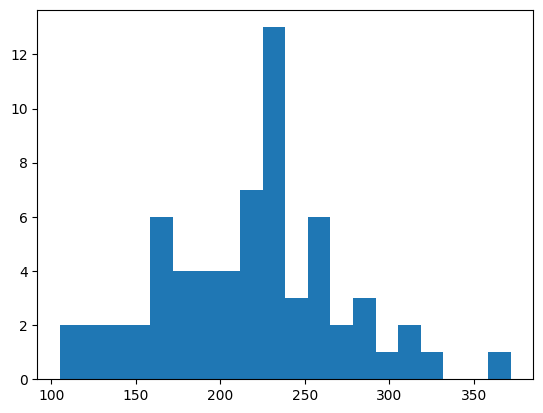

In [4]:
plt.hist(SongData,20)

In [5]:

print(SongData[["DURATION"]].mean())
print(SongData[["DURATION"]].median())
print(SongData[["DURATION"]].mode())


DURATION    218.538462
dtype: float64
DURATION    222.0
dtype: float64
   DURATION
0       233


Here is a histogram that displays the duration of every song from the data set. Using functions from the preliz notebook, we see that the mean is 218.5 seconds, the median is 222 seconds, and the mode is 223 seconds. Because the mean < median < mode, we know that the distribution has a negative skew.



### PRIOR

For my mean prior, I chose a Normal distribution because I expect ASAP's song lengths to cluster around a central value with roughly symmetric variation on either side — there’s no reason to believe songs are systematically much shorter or much longer. I set the mean to 240 seconds (4 minutes), since most of his tracks fall around that range, and the standard deviation to 15 seconds to allow reasonable flexibility. This reflects a moderate belief about the average length without being overly restrictive.

<Axes: >

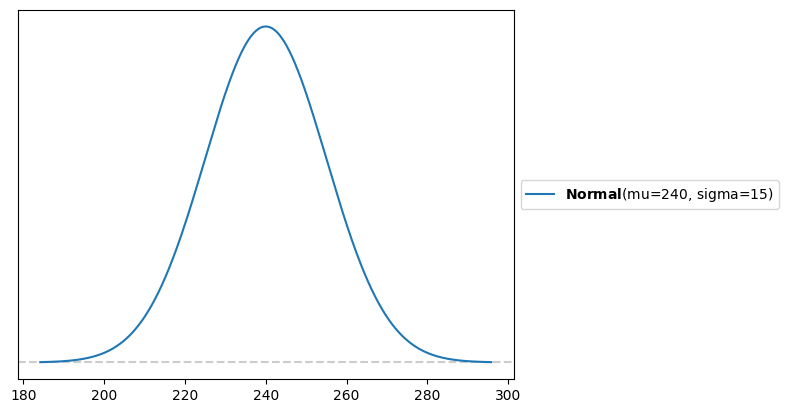

In [ ]:
pz.Normal(mu=240, sigma=15).plot_pdf()


For my standard deviation prior, I chose a HalfNormal distribution because standard deviation values must be positive, and I assume there will be more smaller values than very large ones. The HalfNormal prior includes that this by concentrating probability near zero but still allowing for higher variability if the data suggests it. I set σ = 15 to represent uncertainty about the spread of song lengths. I think most songs won’t deviate too far from the average, but I still want the model to be able to handle songs that vary more in length.

<Axes: >

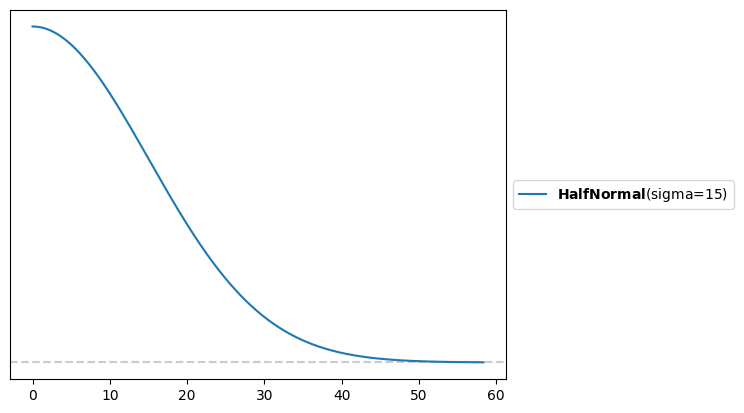

In [ ]:
pz.HalfNormal(sigma=15).plot_pdf()

For my normality prior, I used an Exponential distribution because it ensures that ν (the degrees of freedom in the StudentT distribution) stays positive and can take on a wide range of values. A smaller ν produces heavier tails, which helps the model handle outliers without letting them dominate the results. Setting the rate to 1/5 makes lower ν values (around 5) more likely, meaning I expect the data to have heavier tails than a perfect Normal distribution, but not extremely heavy ones.

<Axes: >

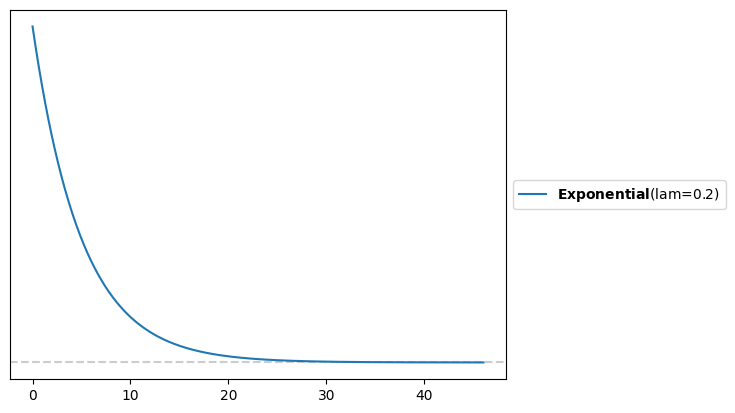

In [ ]:
pz.Exponential(lam = 1/5).plot_pdf()

### INITIAL MODEL

Now, I will combine my three priors with my song data to make my intial model with a StudnetT distribution because it includes mean, standard deviation, and normality.

In [ ]:
with pm.Model() as ASAP_model:

    mu = pm.Normal('mu', mu=240, sigma=15)  # mean prior

    sigma = pm.HalfNormal("sigma", sigma=15)  # standard deviation prior

    nu = pm.Exponential('nu', lam = 1/5)      # normality prior

    initial_model = pm.StudentT("initial_model", mu=mu, sigma=sigma, nu = nu, observed=SongData["DURATION"])

    idata_ASAP = pm.sample()

In [ ]:
pm.sample_posterior_predictive(idata_ASAP, model = ASAP_model, extend_inferencedata = True)

(0.0, 500.0)

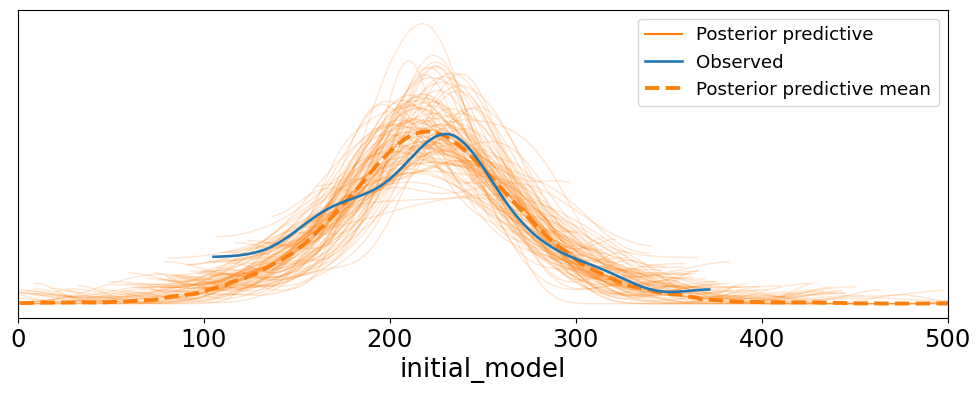

In [8]:
a = az.plot_ppc(idata_ASAP, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
a.set_xlim(0,500)

My priors don't match up great with the observed data. The observed data seems to have a leftward skew, which I didn't account for in my priors. This means I will have to change my distribution model to a distribution that can account for skew.

### FINAL MODEL

For my final model, I will use a SkewStudentT model. I think this is the best distribution for my situation because it allows me to account for the slight skew in the observed data, but I can mostly keep the priors the same because it's still a StudentT distribution. I will account for this slight skew by setting a = 1, and b = 2 in the SkewStudentT line. I'll also increase the sigma in my mean prior to 25, as my posterior predictive mean peak was further left than the observed data peak.

In [ ]:
with pm.Model() as ASAP_model_FINAL:

    mu = pm.Normal('mu', mu=240, sigma=25)  # mean prior

    sigma = pm.HalfNormal("sigma", sigma=15)  # standard deviation prior

    final_model = pm.SkewStudentT('final_model', mu = mu, sigma = sigma, a = 1, b = 2, observed=SongData)

    idata_ASAP_FINAL = pm.sample(2000, tune = 1000)

In [ ]:
pm.sample_posterior_predictive(idata_ASAP_FINAL, model=ASAP_model_FINAL, extend_inferencedata=True)

(100.0, 400.0)

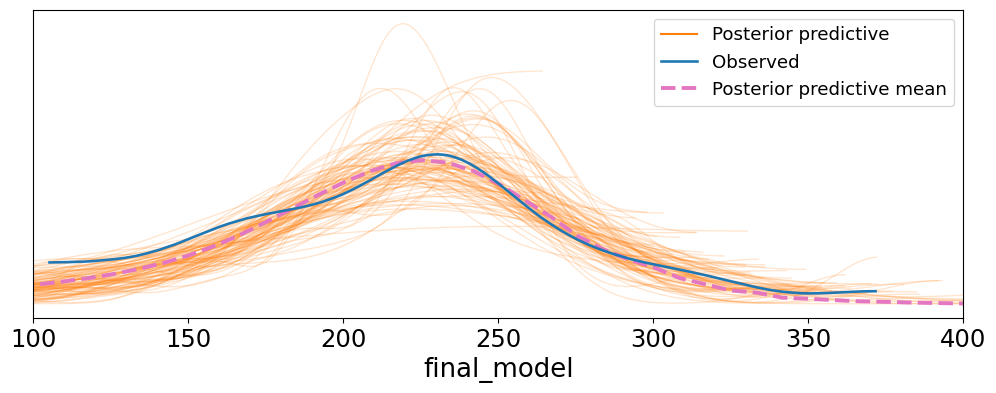

In [11]:
f = az.plot_ppc(idata_ASAP_FINAL, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C6"])
f.set_xlim(100,400)

Now that the slight skew is accounted for, my posterior predictive mean looks a lot more precise next to my observed data. I used guess and check to predict the best a and b values for the StudnetT function. I also added in the x axis range to better display the distribution. I wasn't expecting the distribution to be perfect, as there obviously isn't any rhyme or reason in ASAP Rocky's song length, but I'm happy with how my model turned out.